# Data Analysis 1 - CubeData


In [1012]:
import numpy as np
import math as mt 
import scipy.optimize as opt
import scipy.stats as sta
import matplotlib.pyplot as plt
import csv

In [1013]:
def GetEntries(filename):
    #Read the CSV file and import the data into a corresponding list
    ID = []
    cubeNo = []
    meas_x = []
    meas_y = []
    meas_z = []
    meas_v = []
    unc_x = []
    unc_y = []
    unc_z = []
    unc_v = []
    
    with open(filename) as cubedata:
        entries = csv.reader(cubedata, delimiter=',')
        for row in entries:
            ID.append(row[0])
            cubeNo.append(int(row[1]))
            meas_x.append(float(row[2]))
            meas_y.append(float(row[4]))
            meas_z.append(float(row[6]))
            meas_v.append(float(row[8]))
            unc_x.append(float(row[3]))
            unc_y.append(float(row[5]))
            unc_z.append(float(row[7]))
            unc_v.append(float(row[9]))
        
    return ID, cubeNo, meas_x, meas_y, meas_z, meas_v, unc_x, unc_y, unc_z, unc_v

In [1014]:
def calculate_average(values): 
    sumtot = sum(values)
    avg = sumtot / len(values)
    return avg 

def calculate_variance(values):
    avg = calculate_average(values)
    variance = 0
    for val in values:
        variance += (val - avg) ** 2 
    return variance / (len(values) - 1)

def calculate_stdev(values):
    return np.sqrt(calculate_variance(values))


#some other functions
def Incorrect_V(ID,x,y,z,v):
    #Spot out the incorrect calculation of V
    list_incorrection = []
    for i, vi in enumerate(v):
        v_cal = x[i] * y[i] * z[i]
        if mt.fabs(v_cal - vi) > 0.1 * v_cal: ## Pick out cases where reported V deviated from calculated by 10%
            print(f'{i}: {ID[i]} :\t {x[i],y[i],z[i]}, reported V: {v[i]}, calculated V: {v_cal}.' )
            list_incorrection.append(i)
    return list_incorrection
            
def gaussian(x,mu,sigma):
    #Python has built-in Norm(Gaussian) function. Anyway we can build our own to compare 
    return (1 / (np.sqrt(2 * np.pi * np.power(sigma, 2)))) * \
    (np.power(np.e, -(np.power((x - mu), 2) / (2 * np.power(sigma, 2)))))

In [1015]:
def plot_distribution(meas,meas_index,FilterOutlier,OutlierIndex):

    ##fisrtly, decide to filter out the outliers/incorrectly calculated V items or not
    lists = list(meas)  # copy the list
    if(FilterOutlier):
        for index in OutlierIndex[::-1]:  ## [::-1] to reverse the list of the outlier index
            del lists[index]


    ## Decide the bin number, bin width, plot range and so on.
    num_bins = int(len(lists) / 20)
    pltrange = max(lists) - min(lists)
    lower_edge = min(lists) - 0.05 * pltrange
    upper_edge = max(lists) + 0.05 * pltrange
    binwidth = (upper_edge - lower_edge)/num_bins

    ## build up the Gaussian
    avg_lists = calculate_average(lists)
    stdev_lists = calculate_stdev(lists)
    gau_x = np.linspace(lower_edge, upper_edge, 1000)
    gau_y = len(lists)*binwidth*sta.norm.pdf(gau_x,avg_lists,stdev_lists) ## use the built in norm(Gaussian) function
    #gau_y = len(lists)*binwidth*gaussian(gau_x,avg_lists,stdev_lists)    ## Alternative is to use self-defined Gaussian

   
    labels_x = ["x [mm]", "y [mm]", "z [mm]", "$v [mm^3]$", "$\sigma_x$ [mm]", "$\sigma_y$ [mm]", "$\sigma_z$ [mm]", "$\sigma_v [mm^3]$"]
    labels_y = "Entries/{:.1f}mm".format(binwidth)
    label_gau = "Gaussian($\mu={:.1f},\sigma={:.1f}$)".format(avg_lists,stdev_lists)

    plt.style.use('mystyle.mplstyle')
    #plt.figure(figsize=(8, 6))
    group, nbins, patches= plt.hist(lists, num_bins, color = 'b', label='measurements', alpha=0.5, range = (lower_edge,upper_edge))
    plt.plot(gau_x, gau_y, color = 'r', label=label_gau)
    plt.ylabel(labels_y,position=(0.1,0.8))
    plt.xlabel(labels_x[meas_index],position=(0.9,0.1))
    plt.xlim(lower_edge, upper_edge)
    plt.ylim(0, 1.25*group.max())
    plt.grid(True, alpha=0.25)
    plt.legend(loc='best')

In [1016]:
def plot_CLLevel(meas,meas_index,FilterOutlier,OutlierIndex):
    ##fisrtly, decide to filter out the outliers/incorrectly calculated V items or not
    lists = list(meas)  # copy the list
    if(FilterOutlier):
        for index in OutlierIndex[::-1]:  ## [::-1] to reverse the list of the outlier index
            del lists[index]


    ## Decide the bin number, bin width, plot range and so on.
    num_bins = int(len(lists) / 20)
    pltrange = max(lists) - min(lists)
    lower_edge = min(lists) - 0.05 * pltrange
    upper_edge = max(lists) + 0.05 * pltrange
    binwidth = (upper_edge - lower_edge)/num_bins

    ## build up the Gaussian
    avg_lists = calculate_average(lists)
    stdev_lists = calculate_stdev(lists)
    gau_x = np.linspace(lower_edge, upper_edge, 1000)
    gau_y = len(lists)*binwidth*sta.norm.pdf(gau_x,avg_lists,stdev_lists) ## use the built in norm(Gaussian) function
    
    labels_x = ["x [mm]", "y [mm]", "z [mm]", "$v [mm^3]$", "$\sigma_x$ [mm]", "$\sigma_y$ [mm]", "$\sigma_z$ [mm]", "$\sigma_v [mm^3]$"]
    labels_y = "Entries/{:.1f}mm".format(binwidth)
    label_gau = "Gaussian($\mu={:.1f},\sigma={:.1f}$)".format(avg_lists,stdev_lists)

    plt.style.use('mystyle.mplstyle')
    #plt.figure(figsize=(8, 6))
    #group, nbins, patches= plt.hist(lists, num_bins, edgecolor='None',label='measurements', alpha=0.25, range = (lower_edge,upper_edge))
    group, nbins, patches= plt.hist(lists, num_bins, label='measurements',edgecolor='b', facecolor="None", alpha=1.0, range = (lower_edge,upper_edge), lw=2 )
    plt.plot(gau_x, gau_y, color = 'r', label=label_gau)

    ##plot CL
    # 1 sigma    
    s1x = np.linspace(avg_lists - stdev_lists, avg_lists + stdev_lists, 10)
    s1y = len(lists)*binwidth*sta.norm.pdf(s1x, avg_lists, stdev_lists)
    plt.fill_between(s1x, s1y, color='#F96849', label="$1\sigma$", alpha=0.75)

    # 2 sigma
    s2x_h = np.linspace(avg_lists + stdev_lists, avg_lists + 2*stdev_lists, 10)
    s2y = len(lists)*binwidth*sta.norm.pdf(s2x_h, avg_lists, stdev_lists)
    plt.fill_between(s2x_h, s2y, color='#F98167', label="$2\sigma$", alpha=0.75)

    s2x_l = np.linspace(avg_lists - stdev_lists, avg_lists - 2*stdev_lists, 10)
    plt.fill_between(s2x_l, s2y, color='#F98167', alpha=0.75)

    # 3 sigma
    s3x_h = np.linspace(avg_lists + 2*stdev_lists, avg_lists + 3*stdev_lists, 10)
    s3y = len(lists)*binwidth*sta.norm.pdf(s3x_h, avg_lists, stdev_lists)
    plt.fill_between(s3x_h, s3y, color='#F19885', label="$3\sigma$", alpha=0.75)

    s3x_l = np.linspace(avg_lists - 2*stdev_lists, avg_lists - 3*stdev_lists, 10)
    plt.fill_between(s3x_l, s3y, color='#F19885', alpha=0.75)


    #greater than 3 sigma
    s4x_h = np.linspace(avg_lists + 3*stdev_lists, upper_edge, 10)
    s4y = len(lists)*binwidth*sta.norm.pdf(s4x_h, avg_lists, stdev_lists)
    plt.fill_between(s4x_h, s4y, color='#F1B9AD', label="$\geq3\sigma$", alpha=0.75)

    s4x_l = np.linspace(avg_lists - 3*stdev_lists, lower_edge, 10)
    plt.fill_between(s4x_l, s4y, color='#F1B9AD', alpha=0.75)    
    
    plt.ylabel(labels_y,position=(0.1,0.8))
    plt.xlabel(labels_x[meas_index],position=(0.9,0.1))
    plt.xlim(lower_edge, upper_edge)
    plt.ylim(0, 1.5*group.max())
    plt.grid(True, alpha=0.25)
    plt.legend(loc=(0.05,0.48))
    #plt.legend(loc='best')

In [1033]:
def plot_2Ddistribution(meas_a, meas_b, meas_index_a, meas_index_b, FilterOutlier, OutlierIndex):

    ##fisrtly, decide to filter out the outliers/incorrectly calculated V items or not
    lists_a = list(meas_a)  # copy the list
    lists_b = list(meas_b)
    if(FilterOutlier):
        for index in OutlierIndex[::-1]:  ## [::-1] to reverse the list of the outlier index
            del lists_a[index]
            del lists_b[index]


    ## Decide the bin number, bin width, plot range and so on.
    num_bins = int(len(lists_a) / 20)
    pltrange_a = max(lists_a) - min(lists_a)
    lower_edge_a = min(lists_a) - 0.05 * pltrange_a
    upper_edge_a = max(lists_a) + 0.05 * pltrange_a
    binwidth_a = (upper_edge_a - lower_edge_a)/num_bins

    pltrange_b = max(lists_b) - min(lists_b)
    lower_edge_b = min(lists_b) - 0.05 * pltrange_b
    upper_edge_b = max(lists_b) + 0.05 * pltrange_b
    binwidth_b = (upper_edge_b - lower_edge_b)/num_bins
    
   
    labels = ["x [mm]", "y [mm]", "z [mm]", "$v [mm^3]$", "$\sigma_x$ [mm]", "$\sigma_y$ [mm]", "$\sigma_z$ [mm]", "$\sigma_v [mm^3]$"]

    plt.style.use('mystyle.mplstyle')
    #plt.figure(figsize=(8, 6))
    plt.hist2d(lists_a, lists_b, bins=(num_bins, num_bins), cmap=plt.cm.jet)
    
    plt.ylabel(labels[meas_index_b],position=(0.1,0.8))
    plt.xlabel(labels[meas_index_a],position=(0.9,0.1))
    plt.xlim(lower_edge_a, upper_edge_a)
    plt.ylim(lower_edge_b, upper_edge_b)
    plt.grid(True, alpha=0.25)
    plt.colorbar()

In [1034]:
ID, cubeNo, meas_x, meas_y, meas_z, meas_v, unc_x, unc_y, unc_z, unc_v = GetEntries("cubeData_1.csv")

print("Measurements:")
print("x = {:.1f} ± {:.1f}".format(calculate_average(meas_x), calculate_stdev(meas_x)))
print("y = {:.1f} ± {:.1f}".format(calculate_average(meas_y), calculate_stdev(meas_y)))
print("z = {:.1f} ± {:.1f}".format(calculate_average(meas_z), calculate_stdev(meas_z)))
print("v = {:.1f} ± {:.1f}".format(calculate_average(meas_v), calculate_stdev(meas_v)))

print("\nIncorrected calculated volumn:")
incorrections = Incorrect_V(ID,meas_x,meas_y,meas_z,meas_v)

Measurements:
x = 9.0 ± 0.2
y = 10.3 ± 0.3
z = 36.7 ± 0.8
v = 3407.3 ± 158.7

Incorrected calculated volumn:
48: 14.Sep.B04.08 :	 (9.0, 10.5, 36.5), reported V: 3950.0, calculated V: 3449.25.
258: 18.Sep.B02.11 :	 (9.0, 10.0, 32.0), reported V: 3300.0, calculated V: 2880.0.
293: 19.Feb.B02.02 :	 (8.0, 10.0, 37.0), reported V: 3330.0, calculated V: 2960.0.


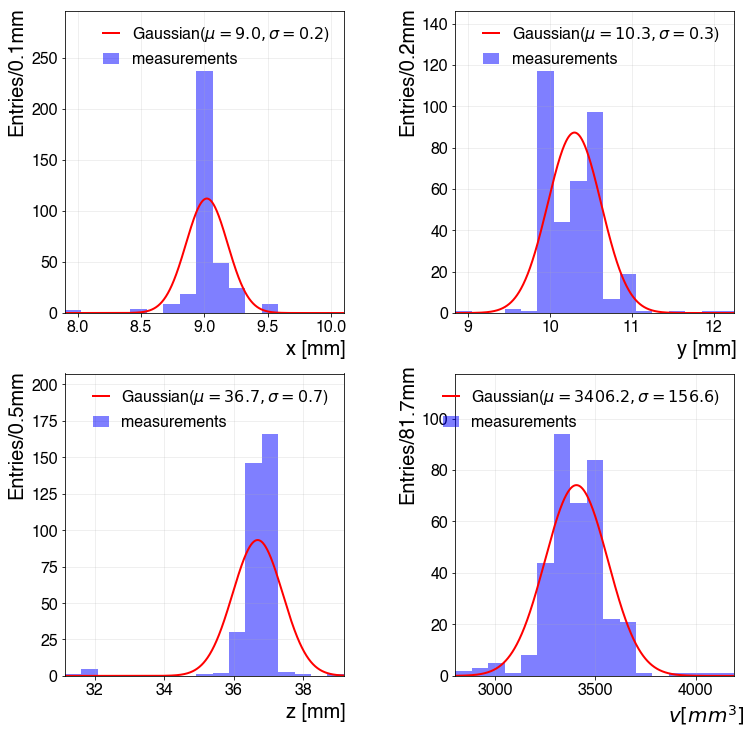

In [1035]:
plt.subplot(2, 2, 1)
plot_distribution(meas_x,0,1,incorrections)
plt.subplot(2, 2, 2)
plot_distribution(meas_y,1,1,incorrections)
plt.subplot(2, 2, 3)
plot_distribution(meas_z,2,1,incorrections)
plt.subplot(2, 2, 4)
plot_distribution(meas_v,3,1,incorrections)

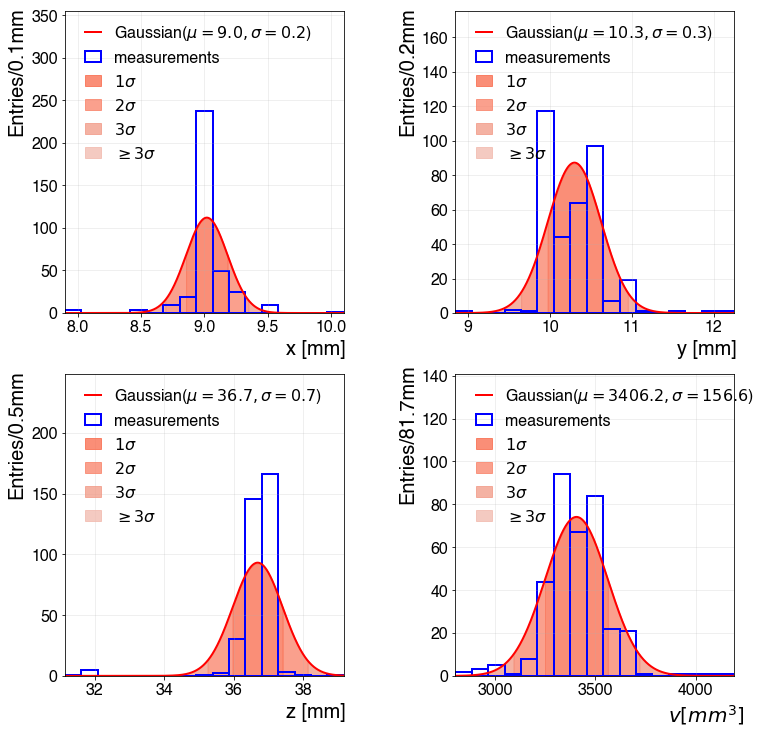

In [1036]:
plt.subplot(2, 2, 1)
plot_CLLevel(meas_x,0,1,incorrections)
plt.subplot(2, 2, 2)
plot_CLLevel(meas_y,1,1,incorrections)
plt.subplot(2, 2, 3)
plot_CLLevel(meas_z,2,1,incorrections)
plt.subplot(2, 2, 4)
plot_CLLevel(meas_v,3,1,incorrections)

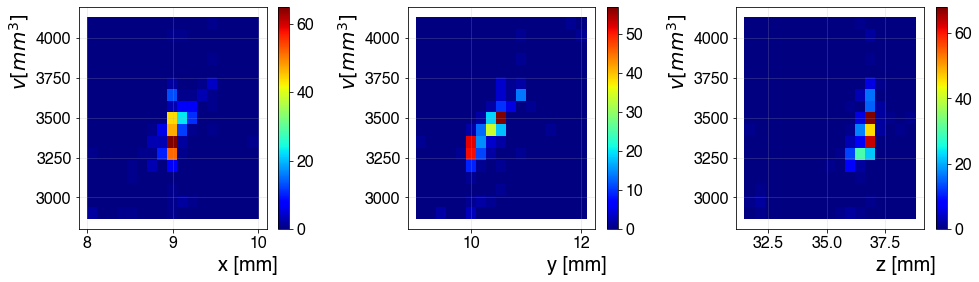

In [1039]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plot_2Ddistribution(meas_x,meas_v,0,3,1,incorrections)
plt.subplot(1, 3, 2)
plot_2Ddistribution(meas_y,meas_v,1,3,1,incorrections)
plt.subplot(1, 3, 3)
plot_2Ddistribution(meas_z,meas_v,2,3,1,incorrections)